# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve,plot_confusion_matrix,auc
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, average_precision_score,confusion_matrix,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from lofo import LOFOImportance, Dataset, plot_importance
from yellowbrick.model_selection import LearningCurve

pd.options.display.float_format = '{:,.2f}'.format

# 2. Reading The Data and Check Missing Values/Data Types

In [2]:
data = pd.read_csv("heart_cleveland_upload.csv")
df = data.copy()
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.10,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.80,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.60,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.40,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.80,1,0,0,0


In [3]:
# Checking Missing Values:
df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [4]:
# Checking Data Types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [5]:
# Checking if features are really numeric:

for i in df.columns:
    if df[i].nunique() < 10:
        print(df[i].value_counts())

1    201
0     96
Name: sex, dtype: int64
3    142
2     83
1     49
0     23
Name: cp, dtype: int64
0    254
1     43
Name: fbs, dtype: int64
0    147
2    146
1      4
Name: restecg, dtype: int64
0    200
1     97
Name: exang, dtype: int64
0    139
1    137
2     21
Name: slope, dtype: int64
0    174
1     65
2     38
3     20
Name: ca, dtype: int64
0    164
2    115
1     18
Name: thal, dtype: int64
0    160
1    137
Name: condition, dtype: int64


**So far we saw that,**
* No missing values.
* Data types are correct.
* Having only 297 observations.
* Actual numerical features: age, trestbps, chol, thalach, oldpeak
* Categorical features: sex, cp, fbs, restecg, exang, slope, ca, thal
* Target: condition

In [6]:
# Let's note the numerical features:
really_nums = ["age","trestbps","chol","thalach","oldpeak"]

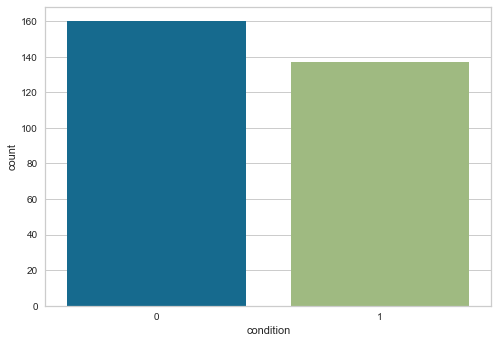

In [7]:
# Checking the balance for our target:
sns.countplot(df.condition,label="Count"); 

In [8]:
print("Condition 1 ratio: %", round(df.condition.value_counts()[0] / df.condition.count(),4)*100)

Condition 1 ratio: % 53.87


**Good, target is not imbalanced. No need to worry. Let's start building base model:**

# Base Model

In [9]:
seed = 40 
train, test = train_test_split(df, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

num_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                 ])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, really_nums)],
                                 remainder = 'passthrough') 


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   LogisticRegression(random_state=seed))
                          ]
                   )

params = [{'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga']},
          
          {'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
         ]

kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True) 
grid = GridSearchCV(pipeline, param_grid = params, cv = kfold, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 266 candidates, totalling 2660 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'thalach',
                                                                          'oldpeak'])])),
                                       ('classifier',
               


Training accuracy: 0.855072463768116
Test accuracy    : 0.8333333333333334


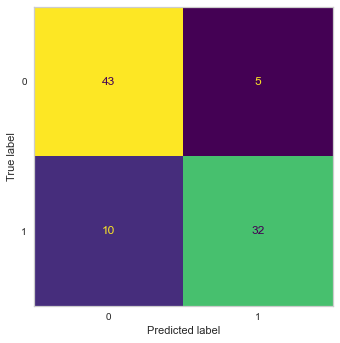

In [10]:
print('\nTraining accuracy:', grid.score(X_train, y_train))
print('Test accuracy    :', grid.score(X_test, y_test))

plot_confusion_matrix(grid, X_test, y_test, colorbar=False)
plt.grid(False)

### Creating a Dataframe to follow models' results:

In [11]:
def print_results(headline, true_value, pred, probs):
    scores=[]
    CM = confusion_matrix(true_value, pred)
    scores.append(headline)
    scores.append(accuracy_score(true_value, pred))
    scores.append(int(CM[1,1]))
    scores.append(int(CM[0,1]))
    scores.append(int(CM[0][0]))
    scores.append(int(CM[1][0]))
    scores.append(precision_score(true_value, pred))
    scores.append(recall_score(true_value, pred))
    scores.append(roc_auc_score(true_value, probs))
    p, r, _ = precision_recall_curve(true_value, probs)
    scores.append(auc(r,p))
    scores.append(f1_score(true_value, pred))
    scores.append(fbeta_score(true_value, pred, beta=2)) 
    return scores

score_names = ['method','accuracy','TP','FP','TN','FN','precision','recall','roc_auc','pr_auc','f1', 'f2']
dfAcc = pd.DataFrame(data=np.zeros(shape=(0,12)), columns = score_names)

In [12]:
# Adding first model:
pred_probs = grid.predict_proba(X_test)[:,1]
scores = print_results('Baseline model', y_test, grid.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78


### Feature Analysis:

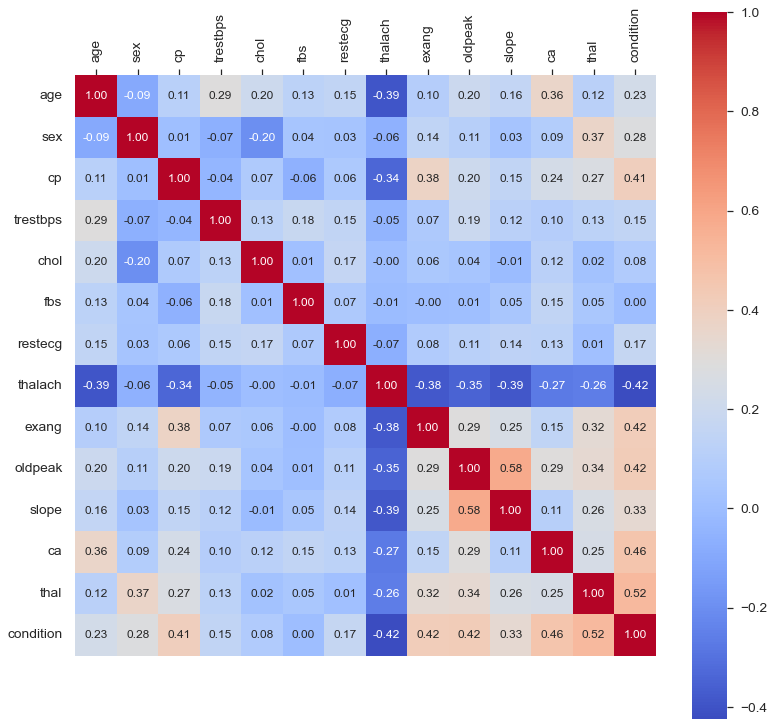

In [13]:
# Checking correlations:

sns.set(font_scale = 1.25)
correlation_matrix = df.corr()
plt.figure(figsize=(13,13))
ax = sns.heatmap(correlation_matrix, vmax=1, cbar=True, square=True, annot=True, fmt='.2f', 
                 annot_kws={'size': 12}, cmap='coolwarm')
ax.xaxis.set_ticks_position('top')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#### As can be seen, "fbs" and "chol" have no correlations with the target. These two features will likely be dropped.
#### Let's check features with Lofo Importance (Leave One Feature Out):

In [14]:
grid.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

  0%|          | 0/13 [00:00<?, ?it/s]

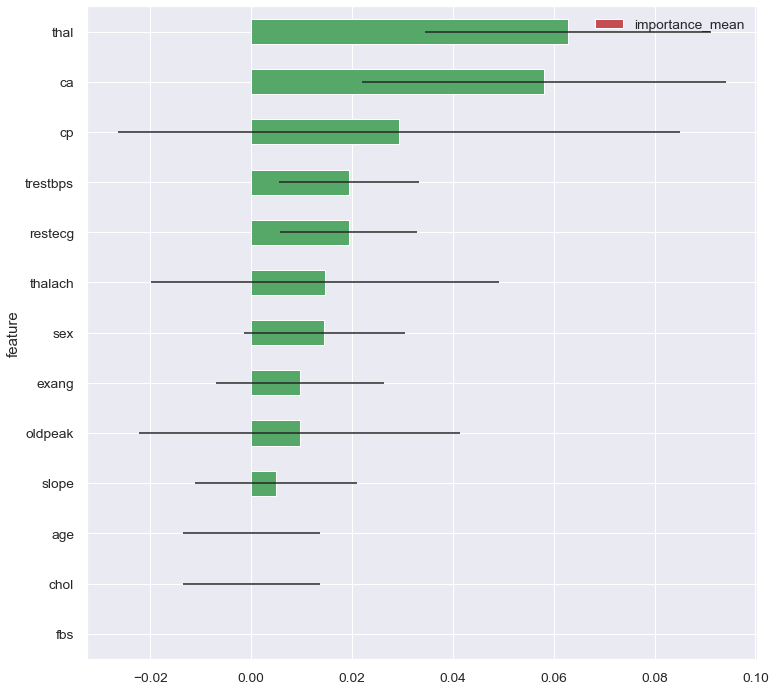

In [15]:
model1 = LogisticRegression(random_state=0,C=0.1,penalty="l2",solver="newton-cg")
model1.fit(X_train,y_train)

dataset = Dataset(df=train, target='condition', features=[col for col in df.columns if col != 'condition'])
lofo_imp = LOFOImportance(dataset, model=model1,scoring='neg_mean_squared_error')
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 12))

**As we guessed, "fbs" and "chol" turned out to be unimportant. Since "age" has some correlation with the target, we'll keep it for now.**

# Model 1 (Dropping 2 features acc. to the LOFO)

In [16]:
df_for_model2 = df.drop(["chol","fbs"],axis=1)
really_nums = ["age","trestbps","thalach","oldpeak"]

seed = 40 
train, test = train_test_split(df_for_model2, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

num_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                 ])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, really_nums)],
                                 remainder = 'passthrough') 


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   LogisticRegression(random_state=seed))
                          ]
                   )

params = [{'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga']},
          
          {'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
         ]

kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True) 
grid2 = GridSearchCV(pipeline, param_grid = params, cv = kfold, verbose = 1, n_jobs = -1)
grid2.fit(X_train, y_train)

Fitting 10 folds for each of 266 candidates, totalling 2660 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'thalach',
                                                                          'oldpeak'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=40))]),
             n_jo


Training accuracy: 0.8502415458937198
Test accuracy    : 0.8444444444444444


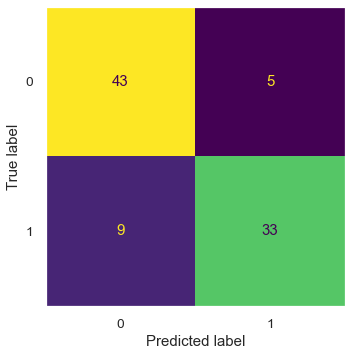

In [17]:
print('\nTraining accuracy:', grid2.score(X_train, y_train))
print('Test accuracy    :', grid2.score(X_test, y_test))

plot_confusion_matrix(grid2, X_test, y_test, colorbar=False)
plt.grid(False)

In [18]:
pred_probs = grid2.predict_proba(X_test)[:,1]
scores = print_results('Dropping 2 Cols(Lofo)', y_test, grid2.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78
1,Dropping 2 Cols(Lofo),0.84,33.00,5.00,43.00,9.00,0.87,0.79,0.93,0.93,0.82,0.80


### There is a very small change but in a good way. Let's check the features with RFE:

In [19]:
a = 1 
score_list =[]

for n in range(1,len(df_for_model2.columns)):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size = 0.30, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,n_features_to_select=n)
    X_trn_rfe = rfe.fit_transform(X_trn,y_trn)
    X_tst_rfe = rfe.transform(X_tst)
    model.fit(X_trn_rfe,y_trn)
    score = model.score(X_tst_rfe,y_tst)
    score_list.append(score)

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=score_list.index(max(score_list))+1)                 
X_rfe = rfe.fit_transform(X_train, y_train)  
model.fit(X_rfe,y_train)        
b = X_train.columns.to_list()
print(rfe.support_)
print(b)

[False False  True False  True False  True  True  True  True  True]
['age', 'sex', 'cp', 'trestbps', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [20]:
to_drop = ['age', 'sex','trestbps','thalach']
to_stay = ['cp','restecg','exang', 'oldpeak', 'slope', 'ca', 'thal']

df_for_model3 = df_for_model2.drop(to_drop,axis=1)
really_nums = ["oldpeak"]

# Model 2 (Dropping 4 more features acc. to the RFE)

In [21]:
seed = 40 
train, test = train_test_split(df_for_model3, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

num_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                 ])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, really_nums)],
                                 remainder = 'passthrough') 


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   LogisticRegression(random_state=seed))
                          ]
                   )

params = [{'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga']},
          
          {'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
         ]

kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True) 
grid3 = GridSearchCV(pipeline, param_grid = params, cv = kfold, verbose = 1, n_jobs = -1)
grid3.fit(X_train, y_train)

Fitting 10 folds for each of 266 candidates, totalling 2660 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['oldpeak'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=40))]),
             n_jobs=-1,
             param_grid=[{'classifier__C': array([0.1 , 0.15, 0...
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['liblinear', 'saga']},
                         {'classifier__C': array(


Training accuracy: 0.8405797101449275
Test accuracy    : 0.8444444444444444


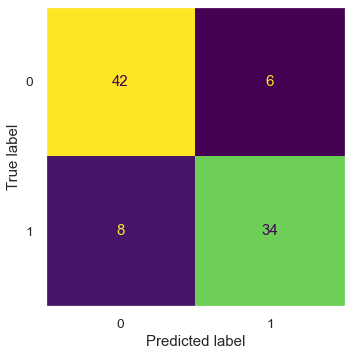

In [22]:
print('\nTraining accuracy:', grid3.score(X_train, y_train))
print('Test accuracy    :', grid3.score(X_test, y_test))

plot_confusion_matrix(grid3, X_test, y_test, colorbar=False)
plt.grid(False)

In [23]:
pred_probs = grid3.predict_proba(X_test)[:,1]
scores = print_results('Dropping 2+4 Cols', y_test, grid3.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78
1,Dropping 2 Cols(Lofo),0.84,33.00,5.00,43.00,9.00,0.87,0.79,0.93,0.93,0.82,0.80
2,Dropping 2+4 Cols,0.84,34.00,6.00,42.00,8.00,0.85,0.81,0.93,0.92,0.83,0.82


#### No difference. But, the simpler the better! We will continue with Model 2. 

<Figure size 576x396 with 0 Axes>

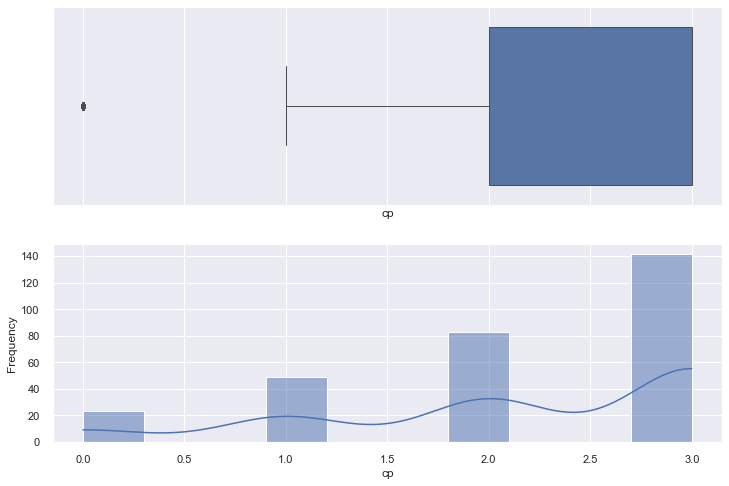

<Figure size 864x576 with 0 Axes>

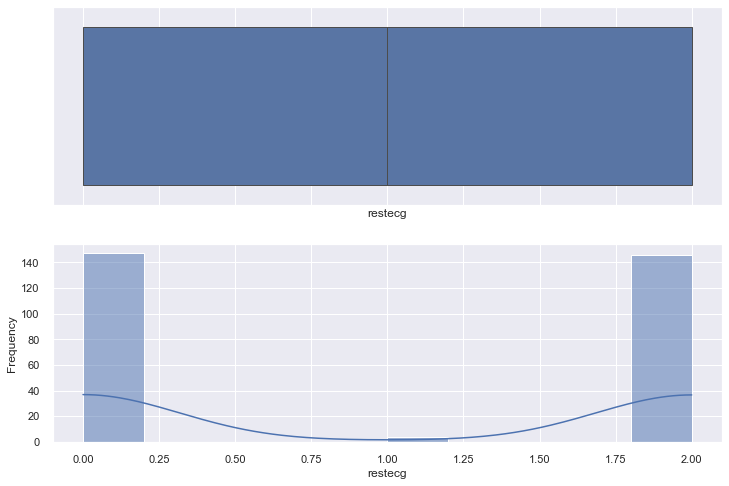

<Figure size 864x576 with 0 Axes>

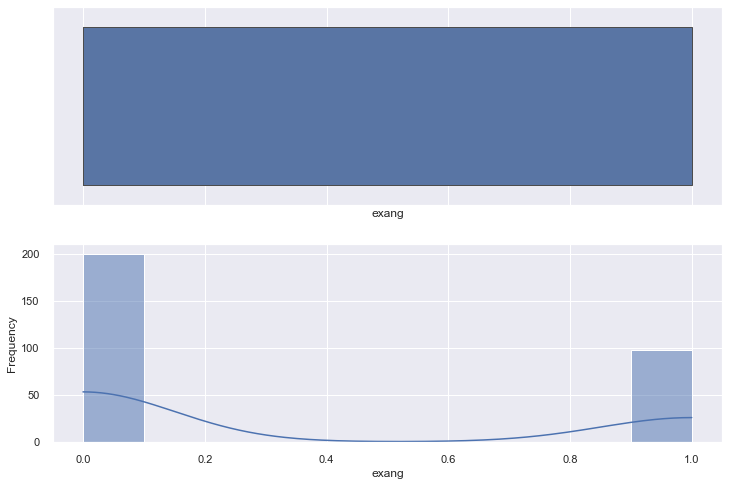

<Figure size 864x576 with 0 Axes>

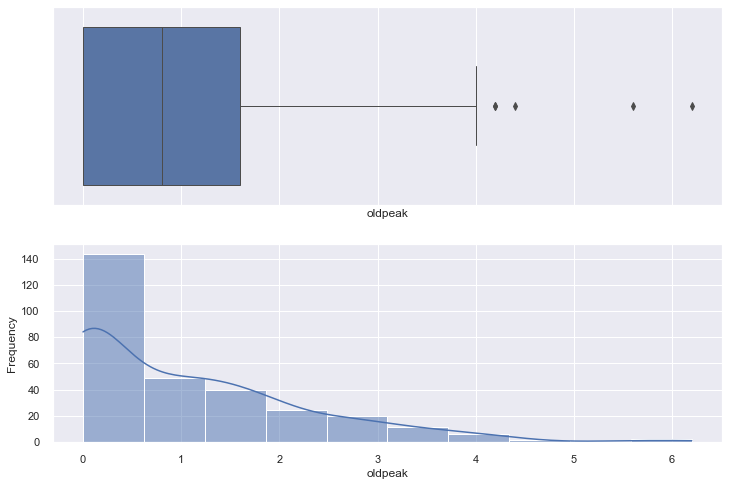

<Figure size 864x576 with 0 Axes>

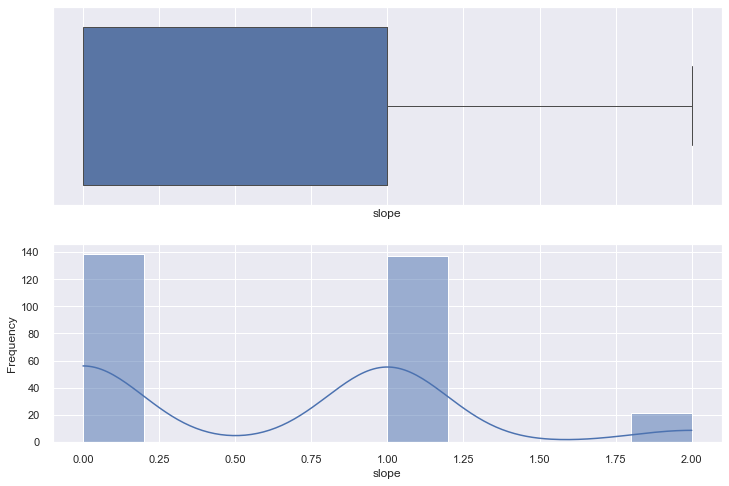

<Figure size 864x576 with 0 Axes>

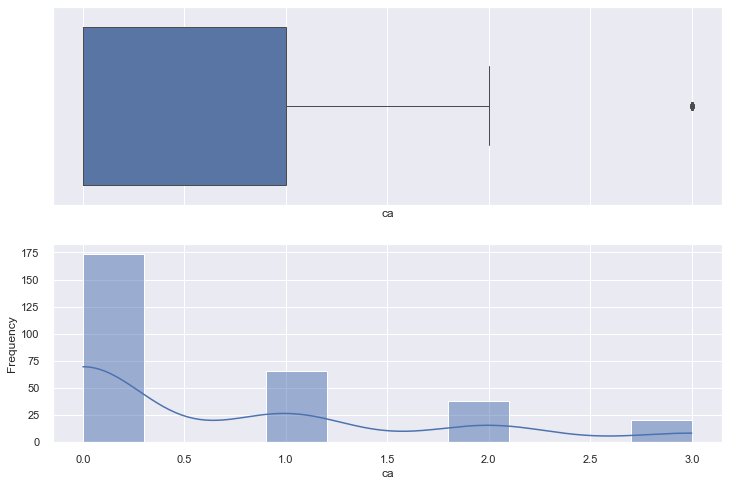

<Figure size 864x576 with 0 Axes>

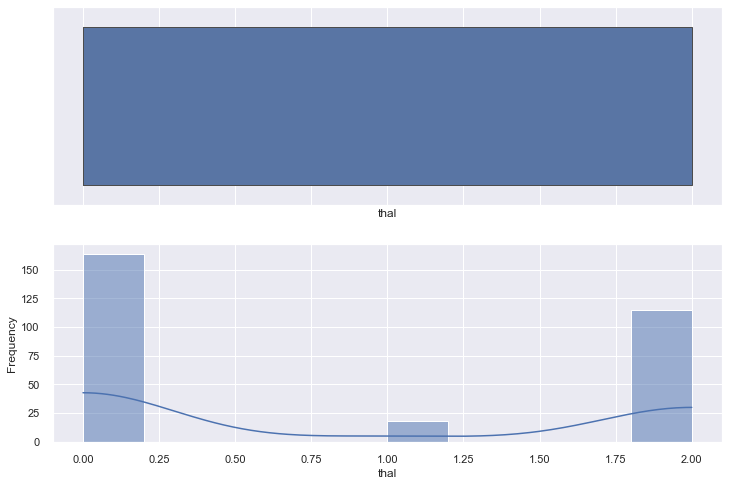

<Figure size 864x576 with 0 Axes>

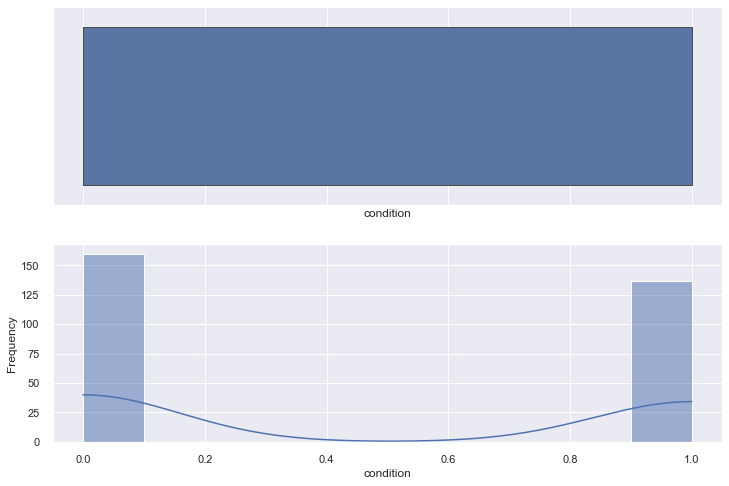

In [24]:
# Checking boxplots and histplots of remaining features:

for i in df_for_model3.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(12, 8)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df_for_model3[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(df_for_model3[i], ax=ax_hist , bins = 10,kde=True)

**Outliers are known to cause problems in classification models. But our data is very small, so I want to try the suppression method instead of the deletion method about outliers.**

#### Suppressing Outliers:

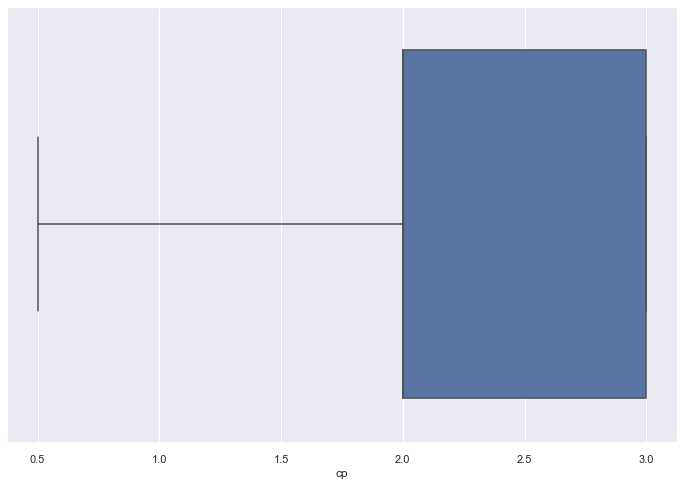

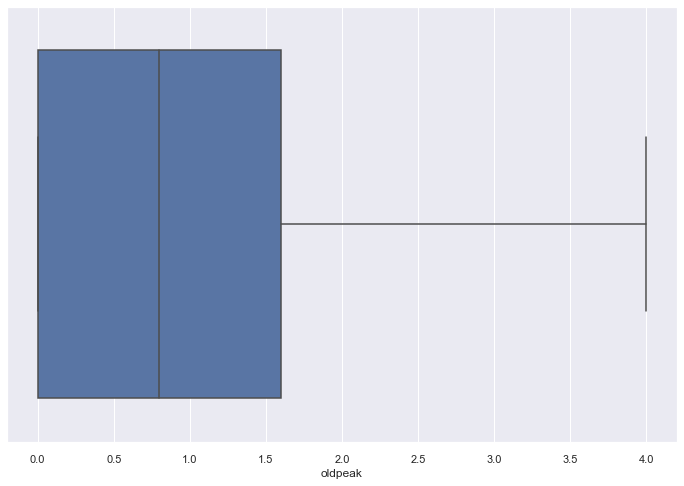

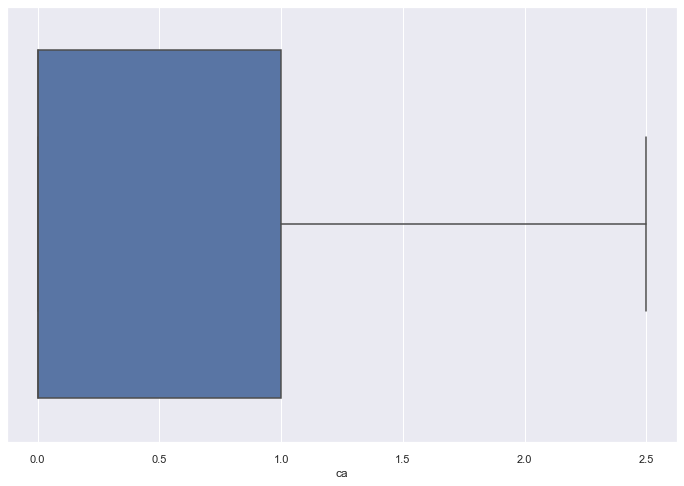

In [25]:
outlier_list = ['cp', 'oldpeak', 'ca']

for i in outlier_list:
    Q1 = df_for_model3[i].quantile(0.25)
    Q3 = df_for_model3[i].quantile(0.75)

    IQR = Q3 - Q1
    ups = Q3 + 1.5*IQR
    lows = Q1 - 1.5*IQR

    outlier_up = df_for_model3[i] > ups
    outlier_low = df_for_model3[i] < lows

    df_for_model3.loc[outlier_up,i] = ups
    df_for_model3.loc[outlier_low,i] = lows

    sns.boxplot(df_for_model3[i])
    plt.show()

# Model 3 - Suppressed Outliers

In [26]:
seed = 40 
train, test = train_test_split(df_for_model3, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

num_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                 ])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, really_nums)],
                                 remainder = 'passthrough') 


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   LogisticRegression(random_state=seed))
                          ]
                   )

params = [{'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l1'], 
           'classifier__solver' : ['liblinear', 'saga']},
          
          {'classifier__C'      : np.arange(0.1, 2.0, 0.05), 
           'classifier__penalty': ['l2'], 
           'classifier__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
         ]

kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True) 
grid4 = GridSearchCV(pipeline, param_grid = params, cv = kfold, verbose = 1, n_jobs = -1)
grid4.fit(X_train, y_train)

Fitting 10 folds for each of 266 candidates, totalling 2660 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['oldpeak'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=40))]),
             n_jobs=-1,
             param_grid=[{'classifier__C': array([0.1 , 0.15, 0...
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['liblinear', 'saga']},
                         {'classifier__C': array(

In [27]:
pred_probs = grid4.predict_proba(X_test)[:,1]
scores = print_results('Outliers', y_test, grid4.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78
1,Dropping 2 Cols(Lofo),0.84,33.00,5.00,43.00,9.00,0.87,0.79,0.93,0.93,0.82,0.80
2,Dropping 2+4 Cols,0.84,34.00,6.00,42.00,8.00,0.85,0.81,0.93,0.92,0.83,0.82
3,Outliers,0.83,33.00,6.00,42.00,9.00,0.85,0.79,0.93,0.92,0.81,0.80


### Results are not good. That's why I will continue with the manual feature analysis on the 2nd model.

In [28]:
df_for_model4 = df_for_model2.drop(['age', 'sex','trestbps','thalach'],axis=1)

**I want to see the effect of features on condition in bar graphs:**

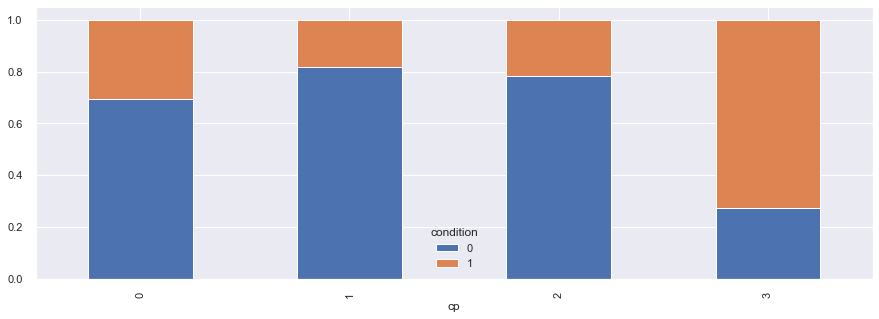

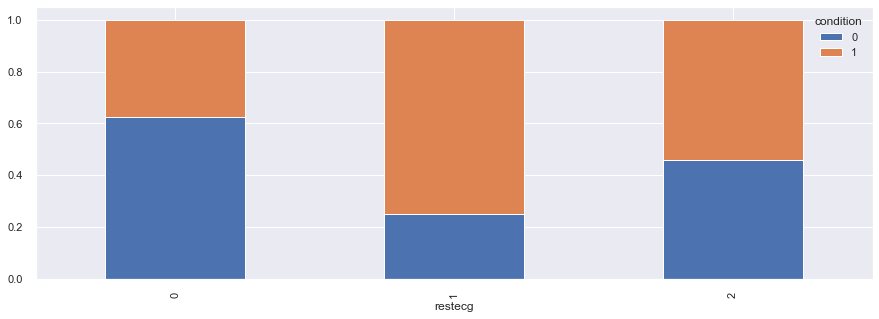

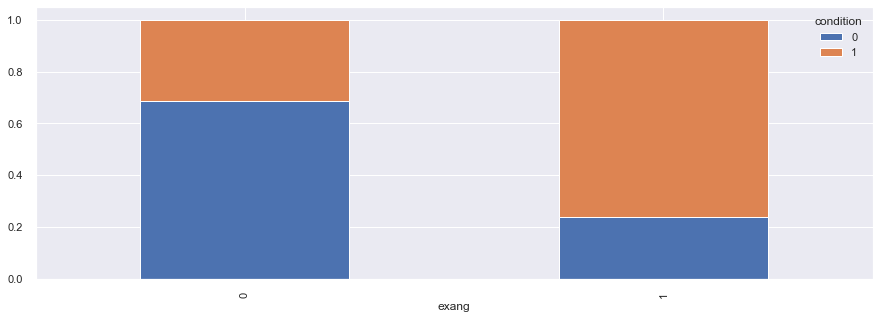

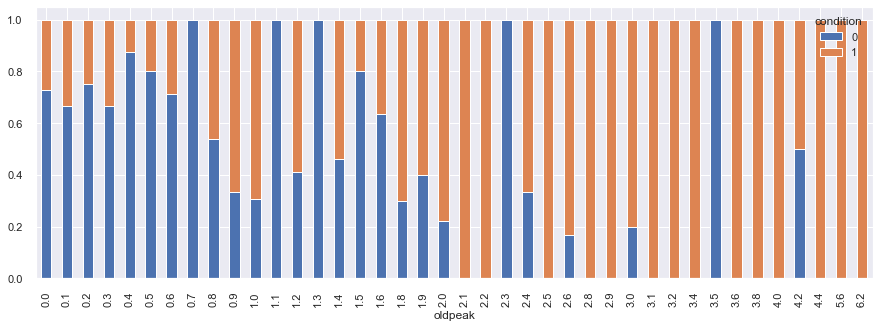

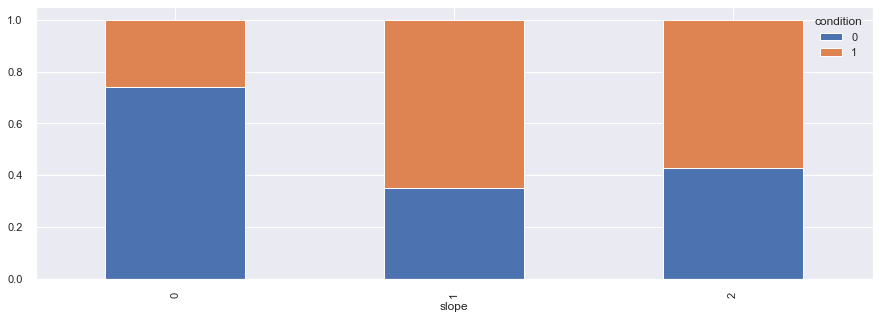

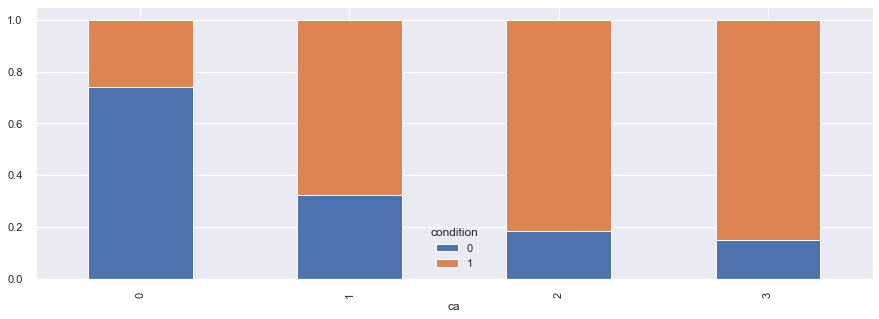

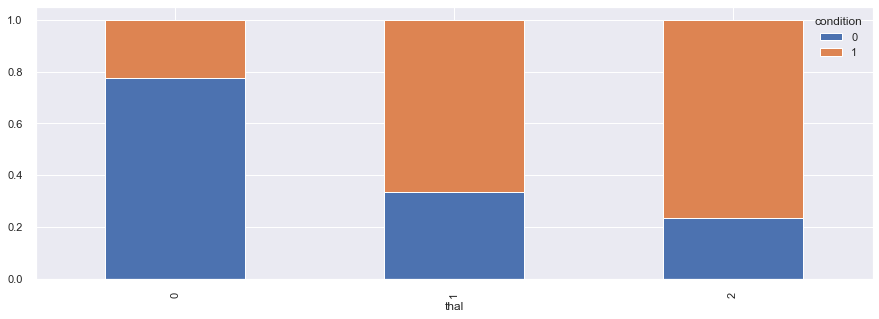

In [29]:
for i in df_for_model4.columns:
    if i != "condition":
        (df_for_model4.groupby(i)['condition'].value_counts(normalize=True).unstack('condition').plot.bar(stacked=True,figsize=(15,5)));

**As a result of my investigations I saw that I can group feature as follows;**
- "oldpeak" : Three groups, 100%, 50%-99%, and others
- "cp" : Two groups, 3 or not
- "restecg" : Two groups, 1 or not
- "slope" : 0 or not
- "ca" : 0 or not
- "thal" : 0 or not

In [30]:
newpeak_list = []
for i in df_for_model4.oldpeak.values:
    a = len(df_for_model4[(df_for_model4.oldpeak == i) & (df_for_model4.condition == 1)]) / len(df_for_model4[(df_for_model4.oldpeak == i)])
    if a == 1:
        newpeak_list.append(2)
    elif a > 0.50:
        newpeak_list.append(1)
    else:
        newpeak_list.append(0)
df_for_model4["new_peak"] = newpeak_list


new_cp_list = []
for i in df_for_model4.cp.values:
    if i == 3:
        new_cp_list.append(1)
    else:
        new_cp_list.append(0)   
df_for_model4["cp_is_3"] = new_cp_list


new_res_list = []
for i in df_for_model4.restecg.values:
    if i == 1:
        new_res_list.append(1)
    else:
        new_res_list.append(0)      
df_for_model4["res_is_1"] = new_res_list


new_slope_list = []
for i in df_for_model4.slope.values:
    if i == 0:
        new_slope_list.append(1)
    else:
        new_slope_list.append(0)       
df_for_model4["slope_is_0"] = new_slope_list


new_ca_list = []
for i in df_for_model4.ca.values:
    if i == 0:
        new_ca_list.append(1)
    else:
        new_ca_list.append(0)
df_for_model4["ca_is_0"] = new_ca_list

new_thal_list = []
for i in df_for_model4.thal.values:
    if i == 0:
        new_thal_list.append(1)
    else:
        new_thal_list.append(0)        
df_for_model4["thal_is_0"] = new_thal_list

# Model 4 - New grouping features:

In [31]:
df_for_model4 = df_for_model4.drop(["oldpeak","cp","restecg","slope","ca","thal"],axis=1)

seed = 40 
train, test = train_test_split(df_for_model4, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

params =  {'C'      : np.arange(0.1, 2.0, 0.05), 
           'penalty': ['l2'], 
           'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
model = LogisticRegression()
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True) 
grid4 = GridSearchCV(estimator=model, param_grid = params, cv = kfold, verbose = 1, n_jobs = -1)
grid4.fit(X_train, y_train)

Fitting 10 folds for each of 190 candidates, totalling 1900 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=40, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95]),
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             verbose=1)

In [32]:
pred_probs = grid4.predict_proba(X_test)[:,1]
scores = print_results('Grouping Method', y_test, grid4.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78
1,Dropping 2 Cols(Lofo),0.84,33.00,5.00,43.00,9.00,0.87,0.79,0.93,0.93,0.82,0.80
2,Dropping 2+4 Cols,0.84,34.00,6.00,42.00,8.00,0.85,0.81,0.93,0.92,0.83,0.82
3,Outliers,0.83,33.00,6.00,42.00,9.00,0.85,0.79,0.93,0.92,0.81,0.80
4,Grouping Method,0.89,36.00,4.00,44.00,6.00,0.90,0.86,0.96,0.96,0.88,0.87


### Looks good, improvement has been made. What about learning curve and optimizing train size?

In [33]:
grid4.best_params_

{'C': 0.7000000000000002, 'penalty': 'l2', 'solver': 'liblinear'}

In [34]:
seed = 40 
train, test = train_test_split(df_for_model4, test_size=0.30, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

model = LogisticRegression(random_state=40,C=0.7000000000000002,penalty="l2",solver="liblinear")
model.fit(X_train,y_train)    

LogisticRegression(C=0.7000000000000002, random_state=40, solver='liblinear')

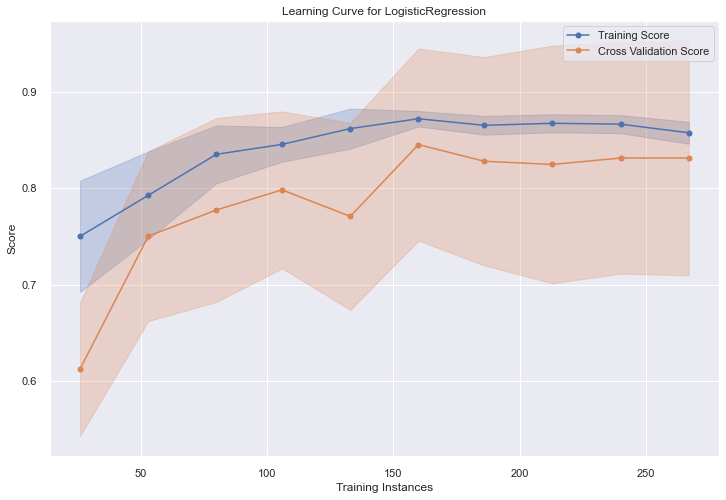

In [35]:
seed = 40 
y = df_for_model4.condition
X = df_for_model4.drop("condition",axis=1)

visualizer = LearningCurve(model, cv=10, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
visualizer.fit(X, y)
visualizer.show();

**As seen in the learning curve, the optimum point corresponds to approximately 60% train and 40% test size. Let's try!**

In [36]:
seed = 40 
train, test = train_test_split(df_for_model4, test_size=0.4, random_state=seed, stratify=df.condition)

y_train = train['condition']
X_train = train.drop('condition', axis=1)
y_test = test['condition']
X_test = test.drop('condition', axis=1)

bestmodel = LogisticRegression(random_state=40,C=0.7000000000000002,penalty="l2",solver="liblinear")
bestmodel.fit(X_train,y_train)    

pred_probs = bestmodel.predict_proba(X_test)[:,1]
scores = print_results('Best Model', y_test, bestmodel.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
dfAcc = pd.concat([dfAcc, dftmp], ignore_index=True)
dfAcc

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Baseline model,0.83,32.00,5.00,43.00,10.00,0.86,0.76,0.92,0.92,0.81,0.78
1,Dropping 2 Cols(Lofo),0.84,33.00,5.00,43.00,9.00,0.87,0.79,0.93,0.93,0.82,0.80
2,Dropping 2+4 Cols,0.84,34.00,6.00,42.00,8.00,0.85,0.81,0.93,0.92,0.83,0.82
3,Outliers,0.83,33.00,6.00,42.00,9.00,0.85,0.79,0.93,0.92,0.81,0.80
4,Grouping Method,0.89,36.00,4.00,44.00,6.00,0.90,0.86,0.96,0.96,0.88,0.87
5,Best Model,0.90,47.00,4.00,60.00,8.00,0.92,0.85,0.97,0.97,0.89,0.87


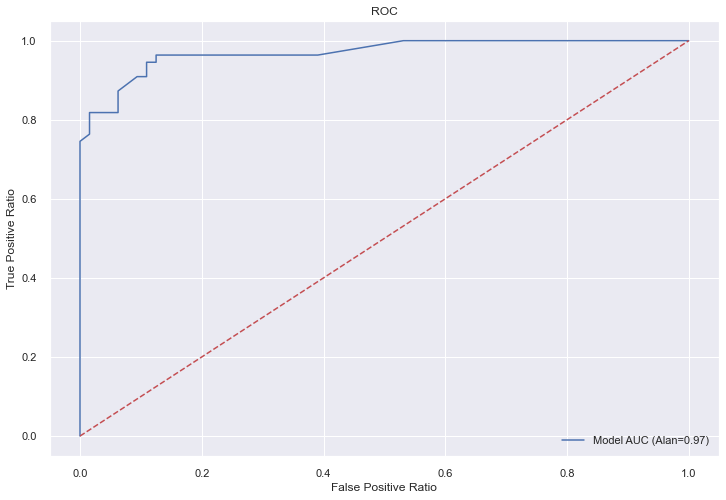

In [38]:
auc = roc_auc_score(y_test,pred_probs)
fpr, tpr,thresold = roc_curve(y_test,bestmodel.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="Model AUC (Alan=%0.2f)" % auc)
plt.plot([0,1],[0,1],"r--")
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.title("ROC")
plt.legend(loc = "lower right")
plt.show()

# We started with 83% accuracy and 92% roc score in our base model. At this point, it is seen again that it is our best model with 90% accuracy and 96% roc score.